### 실습 1

실습1은 녹음된 음성 파일을 화자별로 분류한 뒤, 각 화자의 대표 샘플에서 음향적 특징과 에너지 분포를 종합적으로 살펴보기 위해 작성되었습니다. 먼저 파일명에서 화자 이름을 추출하여 동일 화자의 파일들을 그룹화하고, `librosa` 라이브러리를 통해 각 샘플에서 MFCC와 Mel-스펙트로그램을 계산하여 스펙트럼 정보를 시각화합니다. 이어서 `pyin` 알고리즘으로 추출한 기본 주파수(F0) 궤적을 통해 발화의 피치 변화를, LPC 기반의 포먼트 추정으로 음색 특성을 파악하며, 단시간 에너지 계산으로 음성 강도의 시간적 변화를 함께 표시합니다. 2×3 배열의 서브플롯으로 구성된 이 시각화는 음성 신호의 시간·주파수·강도 측면을 한눈에 보여 줌으로써, 화자 식별이나 음성 품질 분석 등 후속 연구나 모델 개발에 필요한 직관적 인사이트를 제공합니다.

In [2]:
!unzip -o recordings_any.zip -d /content

Archive:  recordings_any.zip
   creating: /content/recordings/
  inflating: /content/recordings/utt_이랑교.wav  
  inflating: /content/__MACOSX/recordings/._utt_이랑교.wav  
  inflating: /content/recordings/utt_백현일.wav  
  inflating: /content/__MACOSX/recordings/._utt_백현일.wav  
  inflating: /content/recordings/utt_조민주.wav  
  inflating: /content/__MACOSX/recordings/._utt_조민주.wav  
  inflating: /content/recordings/utt_강사.wav  
  inflating: /content/__MACOSX/recordings/._utt_강사.wav  
  inflating: /content/recordings/utt_김희건.wav  
  inflating: /content/__MACOSX/recordings/._utt_김희건.wav  


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.6 MB/s eta 0:00:00


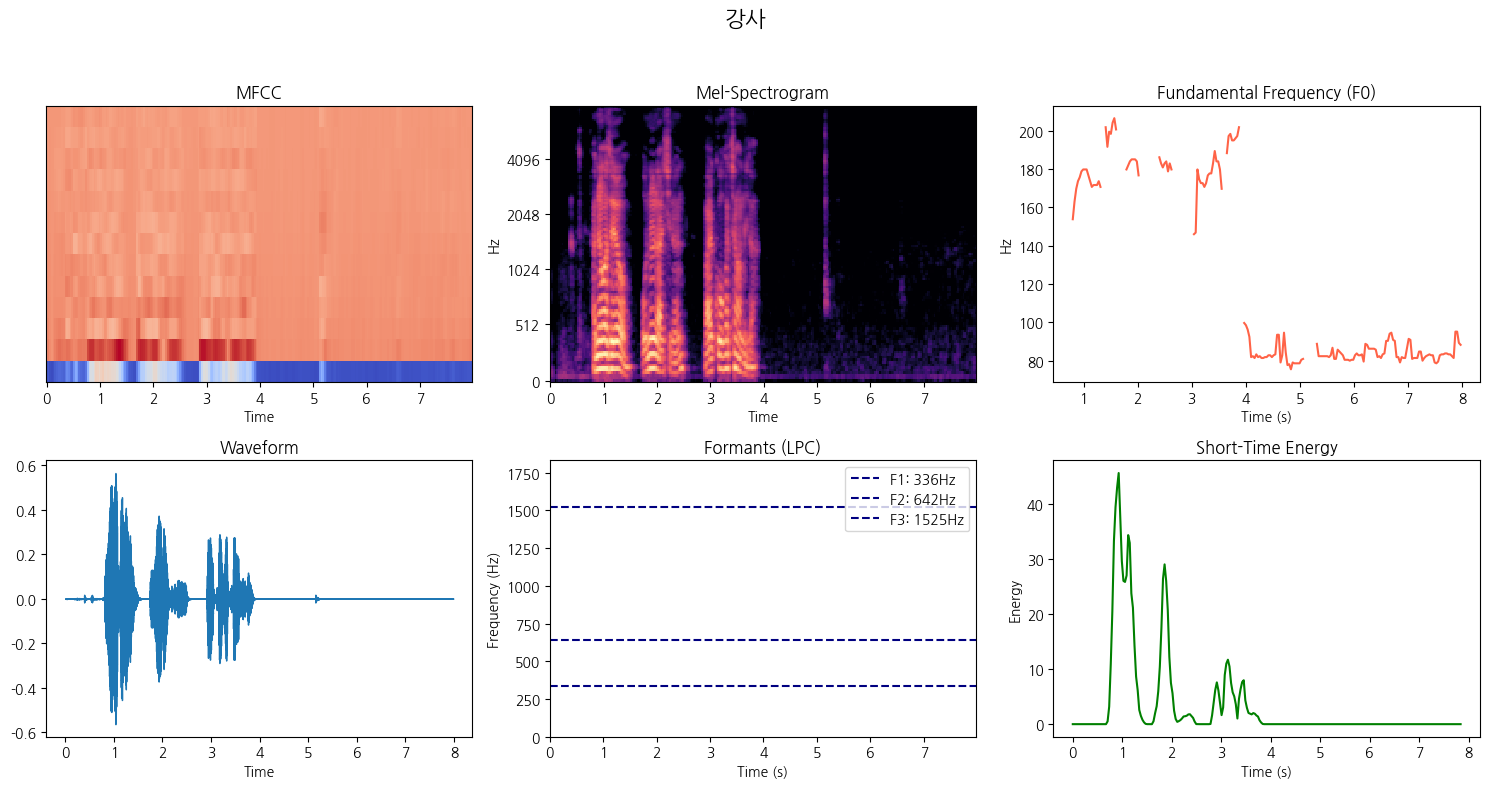

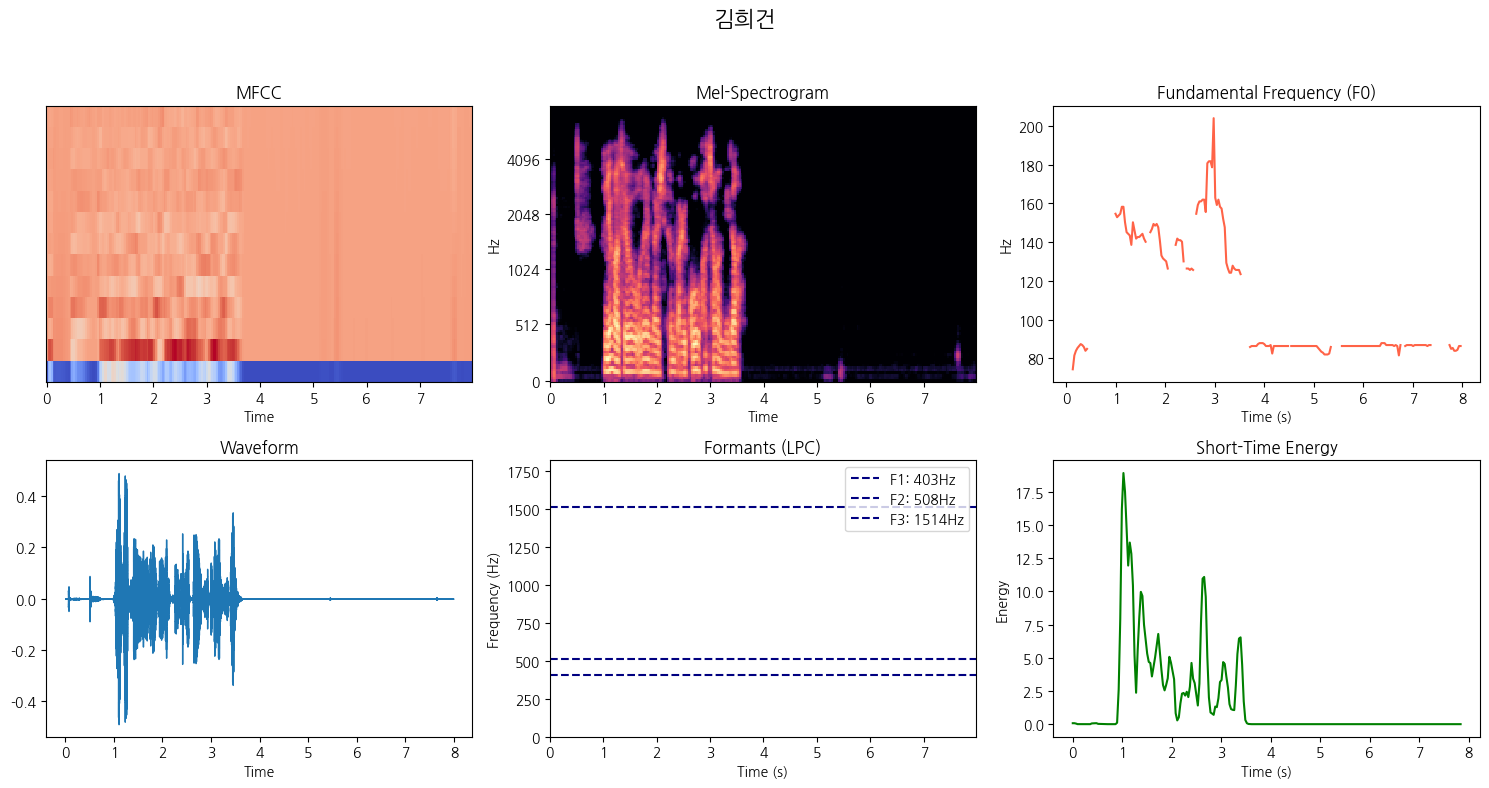

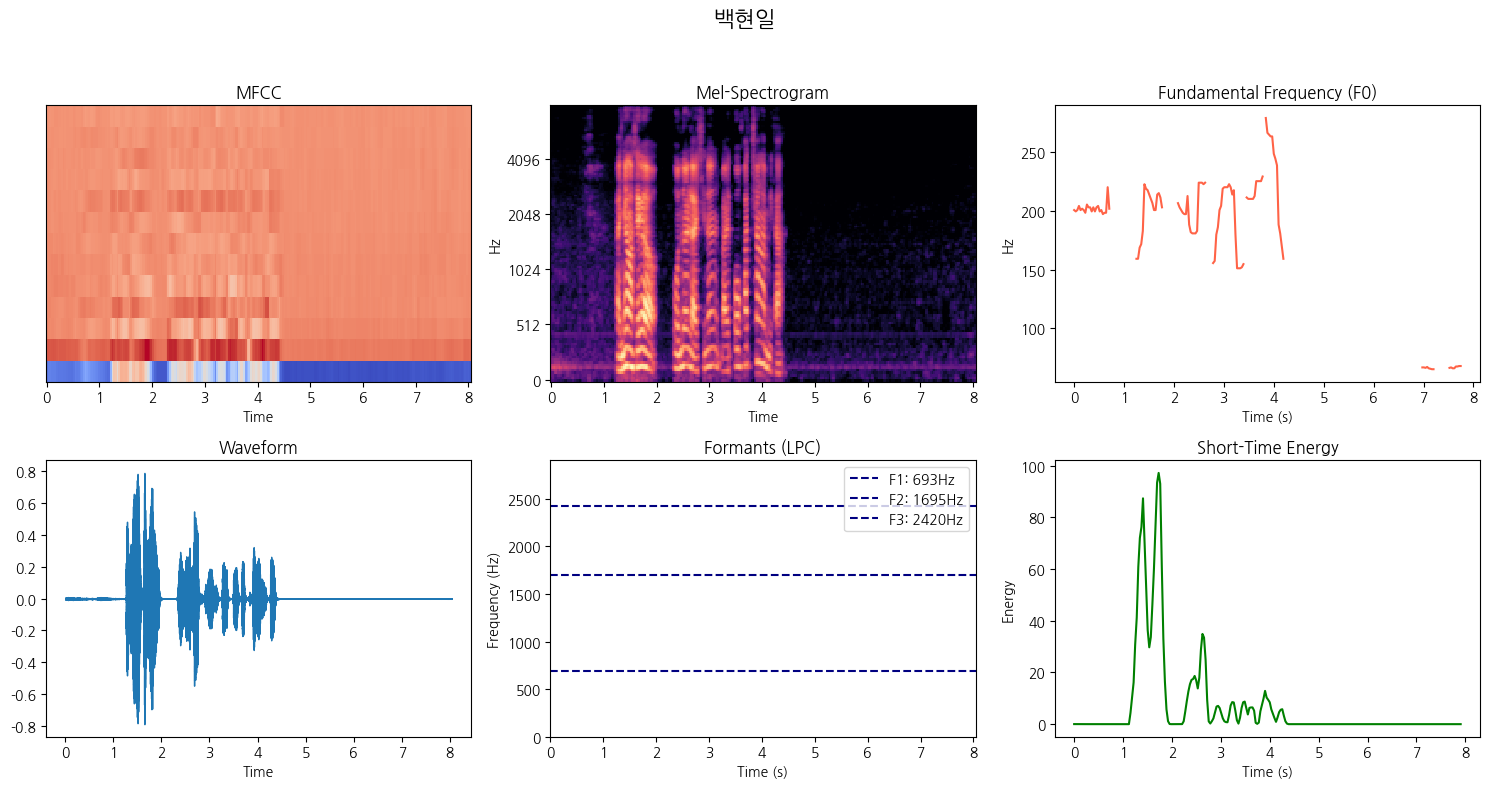

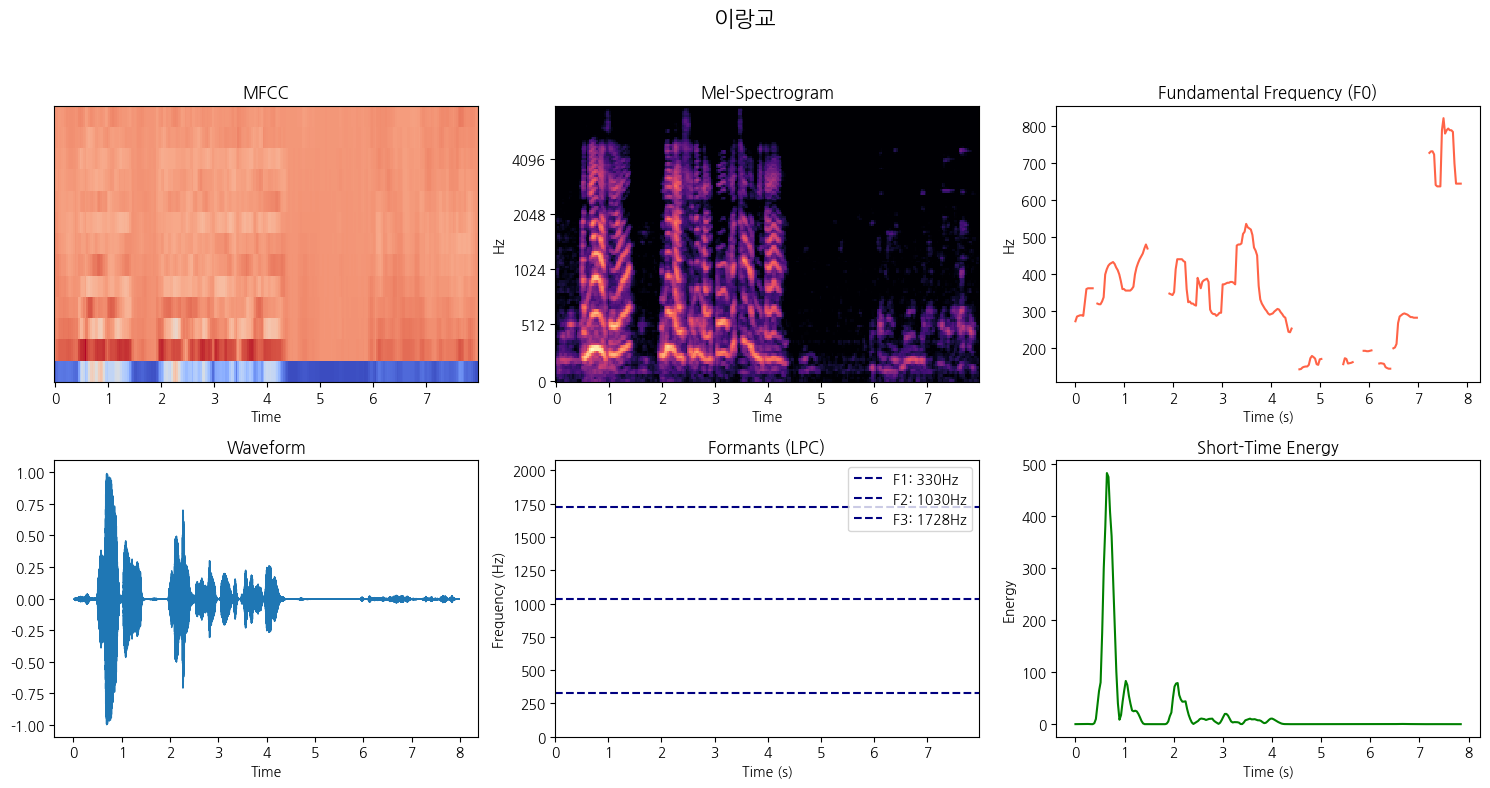

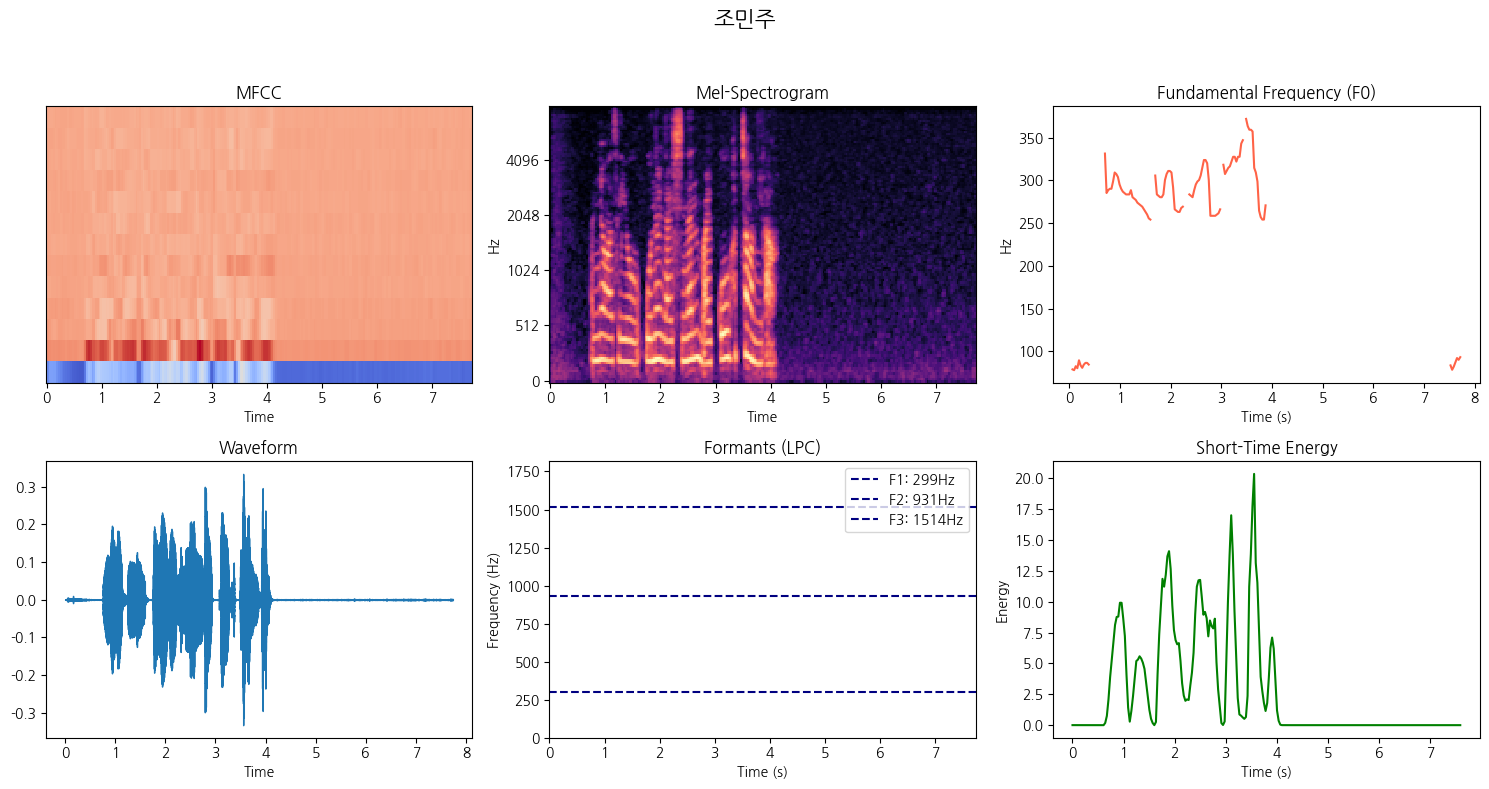

In [3]:
!pip install librosa matplotlib numpy
!pip install koreanize-matplotlib
import koreanize_matplotlib  # 한글 폰트 적용


import os
import unicodedata
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 녹음 파일이 저장된 디렉토리
DATA_DIR = "recordings"
sr = 16000

# 1) .wav 파일 목록 & 화자별 파일 매핑
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".wav")]
speaker_files = {}
for fn in files:
    name_part = os.path.splitext(fn)[0].split("_")[1]
    label = unicodedata.normalize("NFC", name_part)
    speaker_files.setdefault(label, []).append(fn)
SPEAKERS = sorted(speaker_files.keys())

# 2) 특징 추출 함수
def extract_features(file_path, sr=16000, n_mfcc=13, frame_length=2048, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    # MFCC & Mel-Spectrogram
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    # F0 (Fundamental Frequency)
    f0, voiced_flag, _ = librosa.pyin(
        y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'),
        frame_length=frame_length, hop_length=hop_length
    )
    times_f0 = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    # LPC 기반 Formant 추정
    lpc_order = int(sr/1000) + 2
    a = librosa.lpc(y=y, order=lpc_order)
    roots = np.roots(a)
    angles = np.angle(roots)
    freqs = angles * (sr / (2 * np.pi))
    formants = np.sort(freqs[(freqs > 90) & (freqs < sr/2)])[:3]
    # Short-time energy
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    energy = np.sum(frames**2, axis=0)
    times_en = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    return y, mfcc, mel_db, times_f0, f0, formants, times_en, energy

# 3) 시각화
for spk in SPEAKERS:
    spk_files = speaker_files[spk]
    for fn in spk_files[:3]:  # 각 화자 첫 3개 샘플만
        path = os.path.join(DATA_DIR, fn)
        y, mfcc, mel_db, times_f0, f0, formants, times_en, energy = extract_features(path)

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle(f"{spk}", fontsize=16)

        # MFCC
        ax = axes[0,0]
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
        ax.set_title("MFCC")

        # Mel-Spectrogram
        ax = axes[0,1]
        librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title("Mel-Spectrogram")

        # F0 contour
        ax = axes[0,2]
        ax.plot(times_f0, f0, color='tomato')
        ax.set_title("Fundamental Frequency (F0)")
        ax.set_ylabel("Hz")
        ax.set_xlabel("Time (s)")

        # Waveform
        ax = axes[1,0]
        librosa.display.waveshow(y, sr=sr, ax=ax)
        ax.set_title("Waveform")

        # Formants (수평선)
        ax = axes[1,1]
        duration = len(y) / sr
        for i, fr in enumerate(formants, start=1):
            ax.hlines(fr, xmin=0, xmax=duration,
                      colors='navy', linestyles='--',
                      label=f'F{i}: {int(fr)}Hz')
        ax.set_xlim(0, duration)
        ax.set_ylim(0, np.max(formants)*1.2)
        ax.set_title("Formants (LPC)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.legend(loc='upper right')

        # Energy distribution
        ax = axes[1,2]
        ax.plot(times_en, energy, color='green')
        ax.set_title("Short-Time Energy")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Energy")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


구음 장애를 가진 사람들의 음성과 나의 음성에 대해 MFCC, Mel-spectrogram등을 본다.

In [7]:
#라이브러리
from google.colab import output
from base64 import b64decode
from IPython.display import Audio, display
import io
import soundfile as sf

RECORD_SEC = 7

In [8]:
# JavaScript 코드: 마이크 녹음 및 base64 반환
#웹 브라우저에서 마이크를 설정하기 위한 코드
record_js = f"""
async function recordAudio() {{
  const sleep = time => new Promise(resolve => setTimeout(resolve, time));
  const b2text = blob => new Promise(resolve => {{
    const reader = new FileReader();
    reader.onloadend = () => resolve(reader.result);
    reader.readAsDataURL(blob);
  }});

  let stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  let recorder = new MediaRecorder(stream);
  let data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  await sleep({RECORD_SEC * 1000});
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  let blob = new Blob(data);
  return await b2text(blob);
}}
recordAudio();
"""

print(f"▶ 마이크 녹음을 {RECORD_SEC}초 동안 시작합니다...")
audio_base64 = output.eval_js(record_js)

# base64 디코딩 및 저장
audio_bytes = b64decode(audio_base64.split(',')[1])
with open("/content/recordings/utt_khg.wav", "wb") as f:
    f.write(audio_bytes)

display(Audio("/content/recordings/utt_khg.wav"))

▶ 마이크 녹음을 8초 동안 시작합니다...


In [2]:
!pip install librosa matplotlib numpy
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.8 MB/s eta 0:00:00


In [7]:
#구음장애 음성이 44100Hz로 되어있는데 이를 16000Hz으로 sampling rate를 조정
import os
import librosa
import soundfile as sf

def load_and_resample(input_path: str,
                      output_path: str,
                      target_sr: int = 16000):
    """
    음성 파일을 로드하고 샘플링레이트를 변환한 뒤 저장하는 함수

    Args:
        input_path: 원본 음성 파일 경로 (.wav, .mp3 등)
        output_path: 변환된 음성 파일을 저장할 경로 (.wav)
        target_sr: 변환할 샘플링레이트 (Hz)
    """
    # 1. 원본 로드 (기존 sr 유지)
    audio, sr = librosa.load(input_path, sr=None)
    print(f"원본 샘플링레이트: {sr} Hz, 길이: {len(audio)/sr:.2f} 초")

    # 2. 리샘플링
    audio_resampled = librosa.resample(audio, orig_sr=sr,
                                       target_sr=target_sr)
    print(f"변환 후 샘플링레이트: {target_sr} Hz, 길이: {len(audio_resampled)/target_sr:.2f} 초")

    # 3. 파일로 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sf.write(output_path, audio_resampled, target_sr)
    print(f"변환된 파일 저장 완료: {output_path}")

# 사용 예시
if __name__ == "__main__":
    input_file = "/content/utt_patient_fourth.wav"     # 변환 전 파일
    output_file = "/content/recordings/utt_patient16_fourth.wav"  # 변환 후 파일
    load_and_resample(input_file, output_file, target_sr=16000)

원본 샘플링레이트: 44100 Hz, 길이: 8.54 초
변환 후 샘플링레이트: 16000 Hz, 길이: 8.54 초
변환된 파일 저장 완료: /content/recordings/utt_patient16_fourth.wav


/tmp/ipython-input-10-3171955385.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


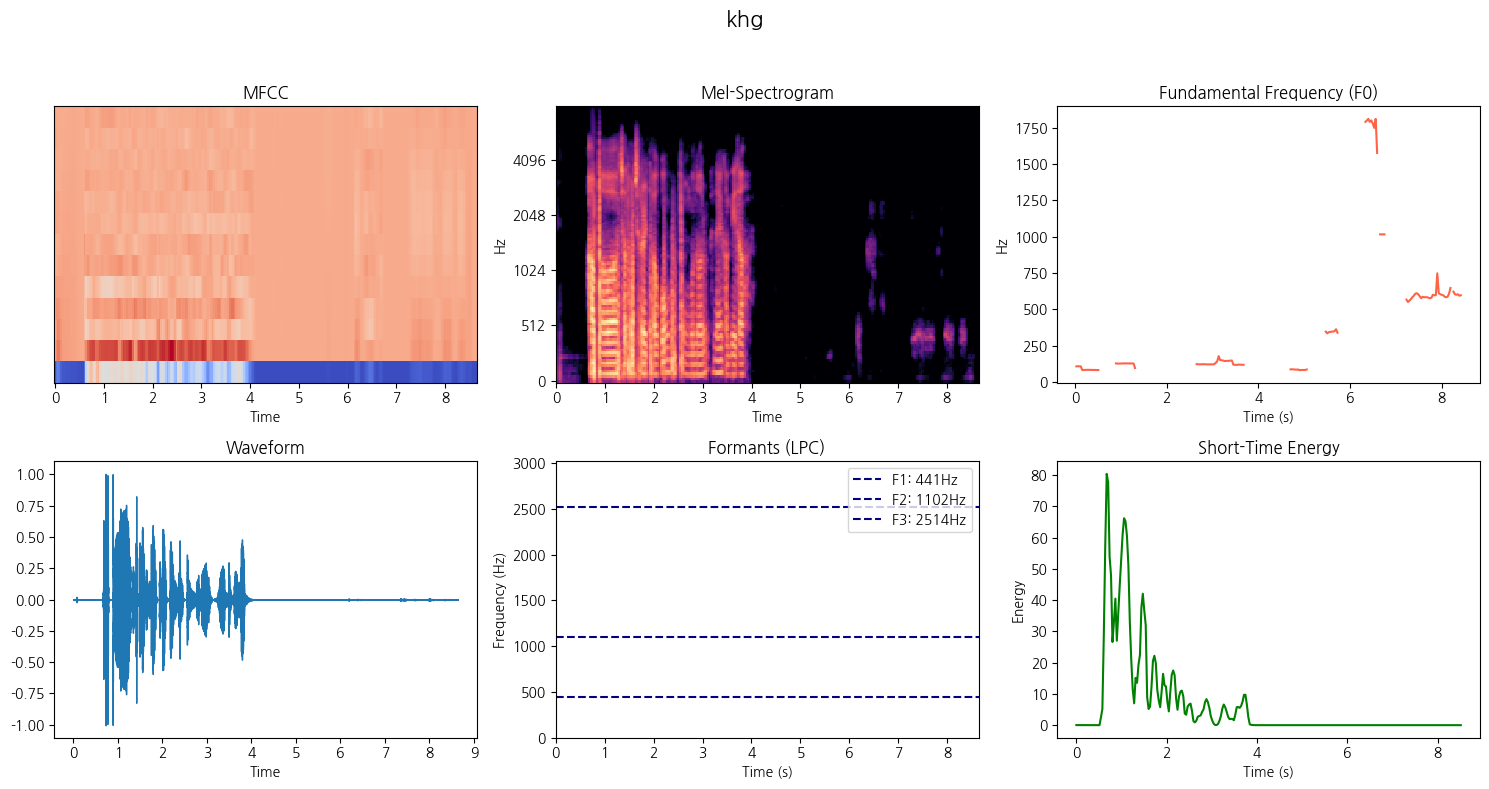

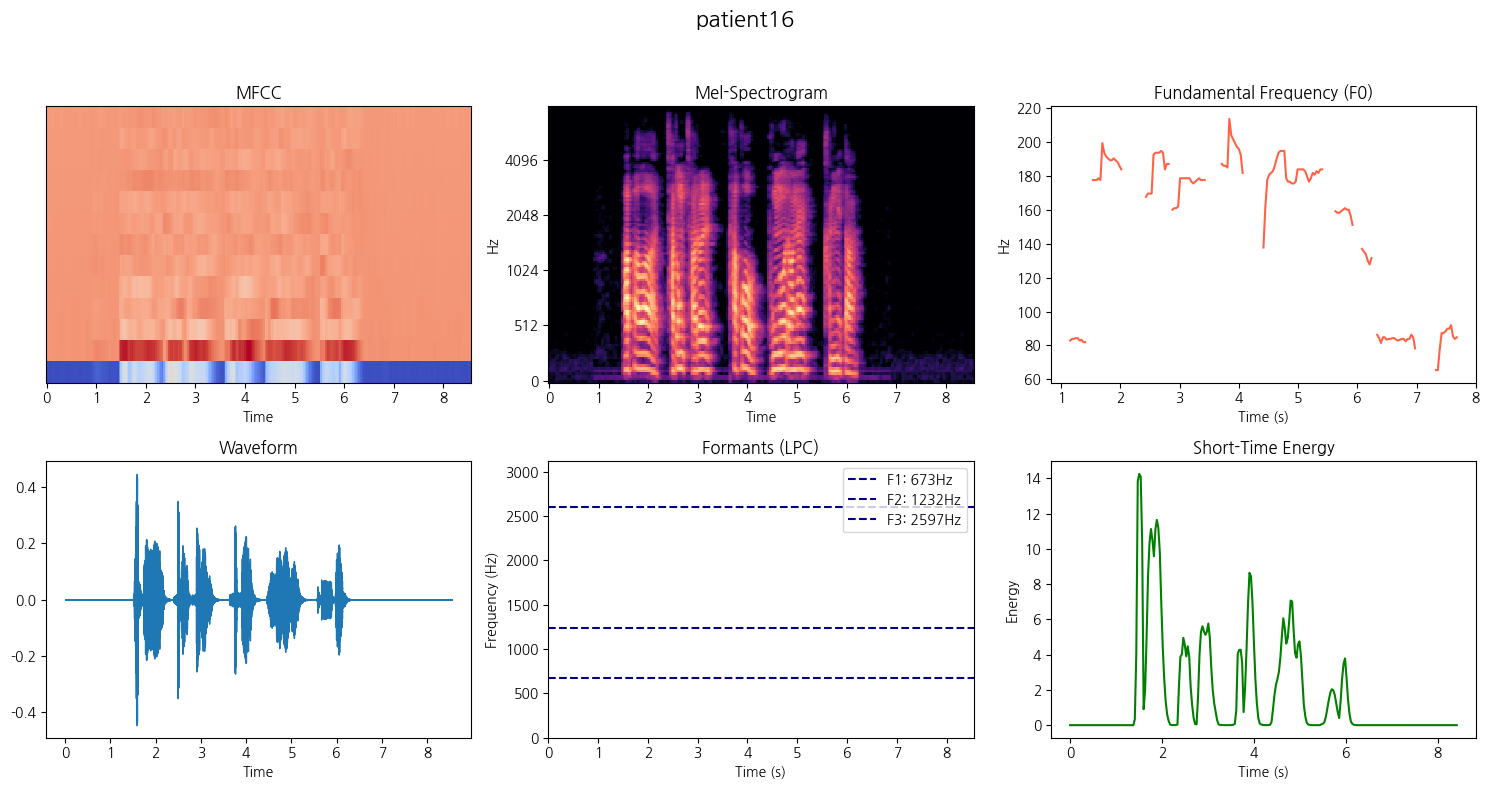

In [10]:
!pip install librosa matplotlib numpy
!pip install koreanize-matplotlib
import koreanize_matplotlib  # 한글 폰트 적용


import os
import unicodedata
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 녹음 파일이 저장된 디렉토리
DATA_DIR = "recordings"
sr = 16000

# 1) .wav 파일 목록 & 화자별 파일 매핑
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".wav")]
speaker_files = {}
for fn in files:
    name_part = os.path.splitext(fn)[0].split("_")[1]
    label = unicodedata.normalize("NFC", name_part)
    speaker_files.setdefault(label, []).append(fn)
SPEAKERS = sorted(speaker_files.keys())

# 2) 특징 추출 함수
def extract_features(file_path, sr=16000, n_mfcc=13, frame_length=2048, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    # MFCC & Mel-Spectrogram
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    # F0 (Fundamental Frequency)
    f0, voiced_flag, _ = librosa.pyin(
        y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'),
        frame_length=frame_length, hop_length=hop_length
    )
    times_f0 = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    # LPC 기반 Formant 추정
    lpc_order = int(sr/1000) + 2
    a = librosa.lpc(y=y, order=lpc_order)
    roots = np.roots(a)
    angles = np.angle(roots)
    freqs = angles * (sr / (2 * np.pi))
    formants = np.sort(freqs[(freqs > 90) & (freqs < sr/2)])[:3]
    # Short-time energy
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    energy = np.sum(frames**2, axis=0)
    times_en = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    return y, mfcc, mel_db, times_f0, f0, formants, times_en, energy

# 3) 시각화
for spk in SPEAKERS:
    spk_files = speaker_files[spk]
    for fn in spk_files[:3]:  # 각 화자 첫 3개 샘플만
        path = os.path.join(DATA_DIR, fn)
        y, mfcc, mel_db, times_f0, f0, formants, times_en, energy = extract_features(path)

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle(f"{spk}", fontsize=16)

        # MFCC
        ax = axes[0,0]
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
        ax.set_title("MFCC")

        # Mel-Spectrogram
        ax = axes[0,1]
        librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title("Mel-Spectrogram")

        # F0 contour
        ax = axes[0,2]
        ax.plot(times_f0, f0, color='tomato')
        ax.set_title("Fundamental Frequency (F0)")
        ax.set_ylabel("Hz")
        ax.set_xlabel("Time (s)")

        # Waveform
        ax = axes[1,0]
        librosa.display.waveshow(y, sr=sr, ax=ax)
        ax.set_title("Waveform")

        # Formants (수평선)
        ax = axes[1,1]
        duration = len(y) / sr
        for i, fr in enumerate(formants, start=1):
            ax.hlines(fr, xmin=0, xmax=duration,
                      colors='navy', linestyles='--',
                      label=f'F{i}: {int(fr)}Hz')
        ax.set_xlim(0, duration)
        ax.set_ylim(0, np.max(formants)*1.2)
        ax.set_title("Formants (LPC)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.legend(loc='upper right')

        # Energy distribution
        ax = axes[1,2]
        ax.plot(times_en, energy, color='green')
        ax.set_title("Short-Time Energy")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Energy")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


### 실습 2

실습 2는 화자별로 추출된 x-vector 임베딩 값들의 전체 가우시안 분포를 그려 보고, 그 위에 평균(μ)과 분산(σ²)으로 정의된 가우시안 곡선을 겹쳐 시각화함으로써 실제 임베딩 값 분포가 정규분포에 얼마나 근접한지 확인하기 위해 작성되었습니다. 먼저 `recordings` 디렉토리에서 각 `.wav` 파일을 불러와 파일명에서 화자 레이블을 추출하고, SpeechBrain의 사전학습된 ECAPA-TDNN 모델로 각 발화의 임베딩 벡터를 얻습니다. 그다음 화자별로 얻은 임베딩 행렬을 1차원으로 펼친 뒤 히스토그램으로 밀도 분포를 그립니다. 마지막으로 `scipy.stats.norm`을 이용해 히스토그램의 평균과 표준편차를 기준으로 한 정규분포 곡선을 계산해 동일한 그래프에 플롯합니다. 이 과정을 통해 화자마다 임베딩 값의 분포 형태를 비교하고, 특징 공간에서 화자 임베딩이 얼마나 가우시안 특성을 띠는지 시각적으로 평가할 수 있습니다.

In [10]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
/tmp/ipython-input-11-2145675986.py:8: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from Hugg

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

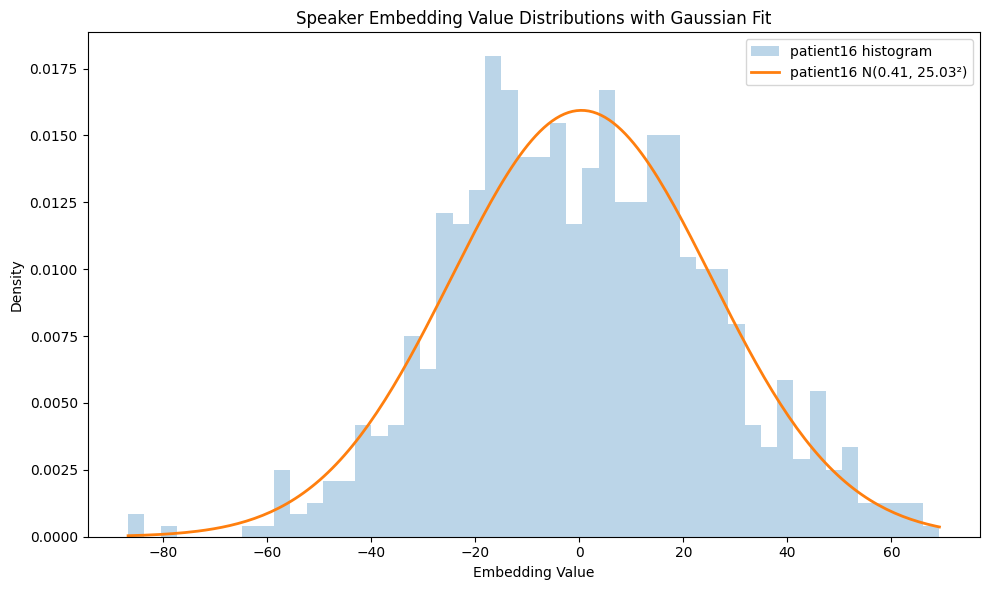

In [11]:
#embedding된 vector들의 분포가 나온다.
import numpy as np
import matplotlib.pyplot as plt
import os
import unicodedata
import torch
import librosa
from speechbrain.pretrained import EncoderClassifier
from scipy.stats import norm

# 1) 데이터 및 모델 로드 (이전과 동일)
DATA_DIR = "recordings"
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".wav")]

# 스피커별 파일 매핑
speaker_files = {}
for fn in files:
    name = os.path.splitext(fn)[0].split("_")[1]
    label = unicodedata.normalize("NFC", name)
    speaker_files.setdefault(label, []).append(fn)

# ECAPA-TDNN 모델 로드
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": "cpu"},
)

# 2) 임베딩 추출
embeddings = {spk: [] for spk in speaker_files}
for spk, fns in speaker_files.items():
    for fn in fns:
        y, _ = librosa.load(os.path.join(DATA_DIR, fn), sr=16000)
        emb = classifier.encode_batch(torch.tensor(y).unsqueeze(0)).squeeze().cpu().numpy()
        embeddings[spk].append(emb)
# 리스트 → numpy 배열
for spk in embeddings:
    embeddings[spk] = np.vstack(embeddings[spk])  # shape (n_samples, emb_dim)

# 3) 분포 시각화
plt.figure(figsize=(10, 6))
for spk, embs in embeddings.items():
    # 모든 차원값을 1D로 펼침
    vals = embs.flatten()
    mu, std = vals.mean(), vals.std()

    # 히스토그램
    counts, bins, _ = plt.hist(vals, bins=50, density=True, alpha=0.3, label=f"{spk} histogram")

    # 가우시안 PDF 곡선
    x = np.linspace(bins[0], bins[-1], 200)
    pdf = norm.pdf(x, loc=mu, scale=std)
    plt.plot(x, pdf, lw=2, label=f"{spk} N({mu:.2f}, {std:.2f}²)")

plt.title("Speaker Embedding Value Distributions with Gaussian Fit")
plt.xlabel("Embedding Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


 실습 3은 별도의 학습 없이도 “누가 말했는가”를 검증할 수 있도록 설계되었습니다. 우선 recordings 폴더에 있는 모든 .wav 파일을 찾아 파일명에서 언더스코어 뒤에 나오는 문자열을 화자 이름으로 추출하고, Unicode 정규화(NFC)를 통해 한글 레이블을 일관되게 처리합니다. 다음으로 SpeechBrain의 사전학습된 ECAPA-TDNN 모델을 이용해 음성 신호를 고정 길이의 x-vector 임베딩으로 변환합니다. 각 화자별로 모든 발화 임베딩을 모아 평균을 계산하면, 이 평균 벡터가 해당 화자를 대표하는 프로파일이 됩니다. 검증 단계에서는 새 발화의 임베딩과 주장된 화자의 평균 임베딩 간 코사인 유사도를 측정하여, 설정된 임계값 이상이면 인증을 통과, 그렇지 않으면 실패로 판정합니다.

In [1]:
# 1) 의존성 설치
!pip install torch librosa numpy speechbrain scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:

# 2) 모듈 임포트
import os
import unicodedata
import torch
import librosa
import numpy as np
from speechbrain.pretrained import EncoderClassifier
from sklearn.metrics.pairwise import cosine_similarity

# 3) flat 구조: recordings/utt_화자.wav
DATA_DIR = "recordings"
wav_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".wav")]
if not wav_files:
    raise RuntimeError(f"No .wav files in {DATA_DIR}")

# 4) 화자별 파일 매핑
speaker_files = {}
for fn in wav_files:
    parts = os.path.splitext(fn)[0].split("_", 1)
    if len(parts) < 2:
        continue
    label = unicodedata.normalize("NFC", parts[1])
    speaker_files.setdefault(label, []).append(fn)
speakers = sorted(speaker_files.keys())
print("Speakers:", speakers)

# 5) ECAPA-TDNN 임베딩 모델 로드
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device":"cpu"},
)

def extract_embedding(path):
    """오디오 파일로부터 x-vector 임베딩 추출 (NaN→0 처리)"""
    y, _ = librosa.load(path, sr=16000)
    emb = classifier.encode_batch(torch.tensor(y).unsqueeze(0))
    emb = emb.squeeze().cpu().numpy()
    return np.nan_to_num(emb)

# 6) 화자별 모든 발화 임베딩 수집
embeddings = {}
for spk, fns in speaker_files.items():
    embs = []
    for fn in fns:
        path = os.path.join(DATA_DIR, fn)
        embs.append(extract_embedding(path))
    embeddings[spk] = np.vstack(embs)  # shape=(n_utter, dim)

# 7) Enrollment: 화자별 평균 임베딩 계산 (모든 발화 사용)
mean_emb = {
    spk: emb_matrix.mean(axis=0, keepdims=True)
    for spk, emb_matrix in embeddings.items()
}

# 8) 인증 함수
def verify(path, claimed_spk, threshold=0.7):
    """
    - claimed_spk: '강사', '김희건' 등
    - threshold: 코사인 유사도 임계값, 필요에 따라 조절하세요.
    """
    if claimed_spk not in mean_emb:
        print(f"{claimed_spk}은(는) 등록된 화자가 아닙니다.")
        return
    emb = extract_embedding(path)
    sim = cosine_similarity(mean_emb[claimed_spk], emb.reshape(1, -1))[0,0]
    print(f"{claimed_spk}와의 유사도: {sim:.3f}")
    if sim >= threshold:
        print("✅ 인증 성공")
    else:
        print("❌ 인증 실패")

# 예시 사용
verify("/content/recordings/utt_강사.wav", "강사")
verify("/content/recordings/utt_김희건.wav", "강사")

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
/tmp/ipython-input-3-3825036688.py:7: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Speakers: ['강사', '김희건', '백현일', '이랑교', '조민주']


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from Hugg

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

강사와의 유사도: 1.000
✅ 인증 성공
강사와의 유사도: 0.229
❌ 인증 실패
